Dans ce notebook, je propose de construire un détecteur d'anomalies à partir d'un AutoEncoder.

La détection d'anomalies (en anglais, anomaly detection ou outlier detection) est l'identification d'éléments, d'événements ou d'observations rares qui soulèvent des suspicions en différant de manière significative de la majorité des autres données. https://fr.wikipedia.org/wiki/D%C3%A9tection_d%27anomalies.

Supposons qu'on gère une chambre froide. On décide d'y installer un capteur qui nous donne la température toutes les cinq minutes. Ce détecteur d'anomalie pourra par exemple alerter en cas d'hausse brutale de la température.

Les données peuvent être retrouvés directement sur https://www.kaggle.com/boltzmannbrain/nab ou https://github.com/numenta/NAB.




Le travail se déroule comme suit:
* Chargement et préparation de nos données
* Définition de notre autoencoder et Entrainement 
* Test sur des données avec outliers

## Chargement et préparation des données

In [1]:
import pandas as pd 
import numpy as np


import matplotlib.pyplot as plt

import torch
import torch.nn as nn
torch.manual_seed(42)

import seaborn as sns; sns.set()

sns.set_style('whitegrid')


Je définis une fonction qui charge et plot automatiquement les données.

Les données sont artificielles, un enregistrement toutes les cinq minutes pendant 14 jours.

J'utilise:
* art_daily_small_noise.csv pour l'entrainement de mon AutoEncodeur: données **sans anomalie**
* art_daily_jumpsdown.csv  pour le test: données qui comportent une **anomalie**

In [2]:
def get_data(url='art_daily_small_noise.csv'):
    '''
    inputs:
    -------
    url (string): path to file
    
    returns:
    --------
    
    df: pandas dataframe
    
    '''
    df=pd.read_csv(url, index_col='timestamp',parse_dates=True)
    df.plot(legend=False)
    plt.title(url.split('.')[0])
    return df
    
    
    

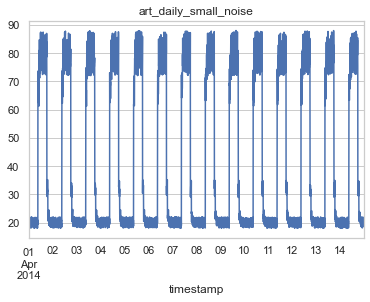

In [3]:
df_noise=get_data()


In [4]:
#pas de temps (longeur du signal)==288 qui correspond aux données pour chaque jour
length_Seq=int(df_noise.groupby(df_noise.index.day).count().loc[1].values)


In [5]:
mean=np.mean(df_noise.values) #On garde ces valeurs pour la normalisation sur les données test
std=np.std(df_noise.values)

def normalize(valeur):
    
    return (np.array(valeur)-mean)/std

In [6]:
df_noise=normalize(df_noise)

Pour pouvoir être entrainer par notre autoencodeur, nous avons besoin de diviser nos données en fenêtre de longeur ***length_Seq***=288. 



Cette  fonction ci_dessus sert à cela.

In [7]:

def create_S(values, length_Seq=length_Seq):
    '''
    inputs:
    ------
    values: list or np array 
    length_Seq:window or timestep
    
    return:
    -------
    r: np array
         shape: (len(values)-length_Seq ,1 ,length_Seq)
    
    
    '''
    output=[]
    for i in range(len(values)-length_Seq):
        output.append(values[i:(i+length_Seq)].reshape(1,-1))
    return np.stack(output)    
        

In [8]:
seq=create_S(df_noise, length_Seq)
seq=torch.tensor(seq) #On convertit en tensor

In [9]:
seq.size() #La taille de notre séquence, 3744 de séquences d'array de tailles 288

torch.Size([3744, 1, 288])

### Construction de notre AutoEncodeur

In [10]:
class Ae(nn.Module):
    '''
    Convolutional AutoEncoder:
    input:
    -----
    x: (B,Cin,l) where B is the batch size, Cin (number of channels), (l length)
    
    parameters:
    -----------
    kernel_size=3
    
    return:
    ------
    y:(B,Cout,l) reconstruction of x
    
    '''

    def __init__(self):
        super(Ae,self).__init__()
        self.encoder=nn.Sequential(
            nn.Conv1d(in_channels=seq.shape[1],out_channels=32, kernel_size=3),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Conv1d(in_channels=32,out_channels=16,kernel_size=3),
            nn.ReLU(True)
                                )
        
        
        self.decoder=nn.Sequential(
            nn.ConvTranspose1d(in_channels=16,out_channels=16,kernel_size=3),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.ConvTranspose1d(in_channels=16,out_channels=32,kernel_size=3),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=32,out_channels=seq.shape[1],kernel_size=1)
                                )
        
        
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x

J'entraine cet autoencodeur à reconstruire les données ***small_noise***.

Ici nous n'avons pas de label pour les données, l'idée est de pouvoir reconstruire les données. 

In [11]:
lr=0.001 #learning rate
epochs=10
history=[]

model=Ae().double()  
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr)

for epoch in range(epochs):
    for s in seq:
        s.resize_(1,1,s.shape[1]) #batch size, number of channels, length
        output=model(s)
        loss=criterion(output,s)
        
        optimizer.zero_grad() # on remet à zéro les gradients
        loss.backward() #Calcule le gradient
        optimizer.step() #mets à jour les poids et biais
        
        
        
    history.append(loss.item())    
        
        
        
        
        

Pour enregistrer ou charger un notre modèle déjà entrainé.

In [2]:

#path='model_state_dict.pt'

#Enregistrer notre modèle
#torch.save(model.state_dict(), path)

#Pour charger notre modèle
#model=Ae().double()
#model.load_state_dict(torch.load(path))
#model.eval()


Dans la figure ci-dessus, je trace l'évolution de notre score ***mse*** mean square error sur nos données test.

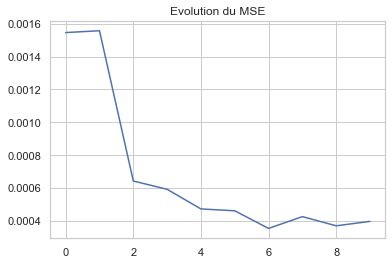

In [12]:
plt.plot(history);
plt.title('Evolution du MSE');

La fonction qui suit permet de faire une prédiction sur un ensemble de séquences;

In [13]:
model=model.eval()
def predict(sequence):
    '''
    input:
    -----
    val: set of sequences
    
    returns:
    -------
    prediction: numpy array
    
    '''
    predictions=[]
    with torch.no_grad():
        for i in range(sequence.shape[0]):
            pred=model(torch.tensor(sequence[i].reshape(1,1,288)))
            predictions.append(pred.numpy().flatten())


    return np.array(predictions).flatten().reshape(-1,1)       

In [14]:
def get_Sequence_for_prediction(liste):
    '''
    return:
    ------
    
    liste, split of liste by day
    '''
    if np.all(liste==df_noise):
        #On divise donc nos données en 14 jours ou chaque est 288 séquences
        split=np.stack(np.vsplit(liste,14)) #14 verticaly splits
    else:
        liste=normalize(liste)
        split=np.stack(np.vsplit(liste,14))
        
    return liste,split    
    
        
    

Regardons comment le modèle a reconstruit les données d'entrainement.

In [15]:
df_noise,val=get_Sequence_for_prediction(df_noise)

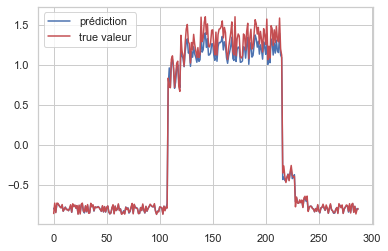

In [16]:
prediction_train=predict(val) #predictions sur les données d'entrainement


plt.plot(prediction_train[0:288],c='b',label='prédiction')
plt.plot(df_noise[0:288],c='r',label='true valeur')

plt.legend();

Nous allons regarder à présent l'écart entre les prédictions et les vraies valeurs. Mais avant, je vous explique la procèdure qui permet de classifier anomalie et non anomalie.

Soit A l'ensemble qui contient tous ces écarts, soit **maxA=max(A)**.

soit $x$ une nouvelle séquence et $xhat$ sa prédiction par le modèle.

Si $|x-xhat|>maxA$, on peut considérer que x est un outlier, car il dépasse l'écart pour toutes les valeurs normales. Ainsi nous avons consruit un clasifieur

In [17]:
#Je calcule les écarts ici que j'appelle mae_train
mae_train = np.mean(np.abs(prediction_train - df_noise),axis=1)

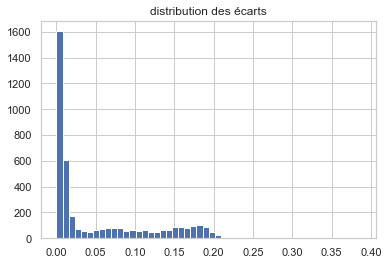

In [18]:
plt.hist(mae_train, bins=50);
plt.title('distribution des écarts');

In [19]:
#maxA définit tout à l'heure correspond à threshold
threshold=np.max(mae_train)

print('threshold: ',threshold)

threshold:  0.3871093635397891


##  Test de notre modèle +détection anomalie sur art_daily_jumpsdown.csv

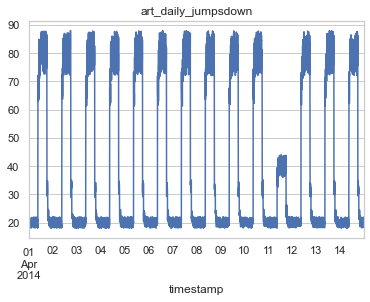

In [20]:
df_jumpdown=get_data(url='art_daily_jumpsdown.csv')


In [21]:
df_jumpdown,val_test=get_Sequence_for_prediction(df_jumpdown)

Dans la figure qui suit, je fais une prédiction sur les données test et je superpose les 2 courbes.

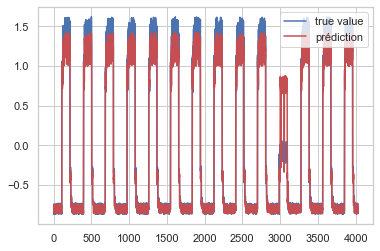

In [22]:
predictions_test=predict(val_test) #prédiction sur ces données




plt.plot(df_jumpdown,label='true value')
plt.plot(predictions_test,c='r',label='prédiction')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1));

Je regarde ensuite les écarts de prédiction.

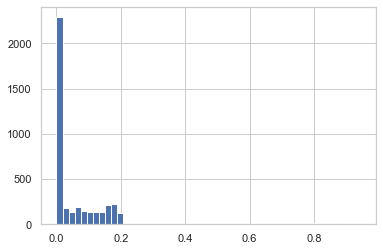

In [23]:
mae_test=np.abs(predictions_test-df_jumpdown)

plt.hist(mae_test,bins=50);

L'idée est donc de comparer les valeurs de ce ***mae_test*** avec le ***threshold*** et utiliser la règle définie tout à l'heure pour séparer les anomalies, des observations normales.

Regardons par exemple le nombre d'anomalies détecté est de 88.

In [24]:
np.sum(mae_test>threshold)

88

AutoEncodeur + Classifieur détecte 88 anomalies, nous allons les visualiser sur nos données pour voir à quoi cela correspond.

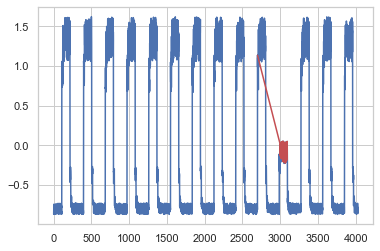

In [25]:
data=pd.DataFrame({'value':df_jumpdown.flatten(),'prediction':predictions_test.flatten()})

fig,ax=plt.subplots()

data.plot(y='value',legend=False,ax=ax)
data[mae_test>threshold].plot(y='value',legend=False,ax=ax,c='r');


L'AutoEncodeur prédit bien l'anomalie.

### Conclusion

Le Convolutional AutoEncodeur semble bien marcher sur cet exemple, cependant au regard de comment on l'a entrainé, ne marche que sur ces données. Comme perspective nous pouvons:
* Entrainer cet AutoEncodeur sur d'autres données séquentielles mais avec plus de  channels ou features
* tuner le batch size (avec plus de ressources), regarder le kernel size
* Test l'AutoEncodeur avec des réseaux récurrents (LSTM en particulier)

Cheikh TOURE